# Business Challenge Projects

##### Author: Masaya Inoue 
##### Published Date: 2024/03/31

### Context 

as a business consultant who has been hired by Bene StudioLinks to an external site. \
(https://benestudio.co/) to understand the MedTech space and find early-stage startups which can be their paying clients in the future.

### Instructions
Goal: Find those early-stage MedTech (Digital Health or Medical Device) startups that have the potential to be successful.

##### Analyze:

**Successful startups**: Profiles of Series B (raised $20mm or more) MedTech companies and their founders/management.

Bene Studio has provided two spreadsheets with data from CrunchbaseLinks to an external site. (https://www.crunchbase.com/Links to an external site.) with information about successful startups:
active-20mm-startups-hult-project.csv
exited-20mm-startups-hult-project.csv

**Unsuccessful startups**: Profiles of companies that stopped operation before Series A (raised less than $3mm) and their founders/management.

Bene Studio has provided a spreadsheet with data from Crunchbase on unsuccessful startups:
closed-startups-hult-project.csv
##### Predict success:
Compare the two profiles by identifying their biggest differences. What can be the reason for some companies achieving greater success than others?
\
**Find patterns in the successful profiles which can be found at pre-seed (raised less than $3mm) to predict success.**

## Setting 

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from collections import Counter

from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier # Ada=Adaptive
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier # MLP = multilayer perceptron
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import ipywidgets as widgets
from IPython.display import display

In [3]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Understanding and Preparation
Begin by thoroughly understanding the structure and content of each CSV file provided.

In [4]:
# Load data from CSV files
successful_df_1 = pd.read_csv('data/active-20mm-startups-hult-project.csv')
successful_df_2 = pd.read_csv('data/exited-20mm-sartups-hult-project.csv')
unsuccessful_df = pd.read_csv('data/closed-startups-hult-project.csv')

# Add labels to each DataFrame
successful_df_1['Status'] = 'Successful'
successful_df_2['Status'] = 'Successful'
unsuccessful_df['Status'] = 'Unsuccessful'

# Concatenate the DataFrames vertically
successful_df = pd.concat([successful_df_1, successful_df_2], ignore_index=True)

# Display the merged DataFrame
print(successful_df.info())
print(unsuccessful_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 40 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Organization Name                              1322 non-null   object 
 1   Organization Name URL                          1322 non-null   object 
 2   Full Description                               1299 non-null   object 
 3   Founded Date                                   1315 non-null   object 
 4   Founded Date Precision                         1315 non-null   object 
 5   Number of Employees                            1297 non-null   object 
 6   Industries                                     1322 non-null   object 
 7   Headquarters Location                          1322 non-null   object 
 8   Description                                    1322 non-null   object 
 9   CB Rank (Company)                              1320 

In [5]:
# List of columns to keep
columns_to_keep = [
    'Organization Name',
    'Full Description',
    'Founded Date',
    'Number of Employees',
    'Industries',
    'Headquarters Location',
    'Description',
    'CB Rank (Company)',
    'Operating Status',
    'Number of Founders',
    'Founders',
    'Number of Funding Rounds',
    'Funding Status',
    'Last Funding Date',
    'Last Funding Amount',
    'Last Funding Type',
    'Last Equity Funding Amount',
    'Last Equity Funding Type',
    'Total Equity Funding Amount',
    'Total Funding Amount',
    'Status'
]

# Create a new DataFrame 'successful_df' with only the selected columns
successful_df = successful_df[columns_to_keep]
unsuccessful_df = unsuccessful_df[columns_to_keep]

In [6]:
# Concatenate successful_df and unsuccessful_df
combine_df = pd.concat([successful_df, unsuccessful_df], ignore_index=True)

# Define the path to save the combined DataFrame as a CSV file
csv_file_path = 'combined_data.csv'

# Export the combined DataFrame to a CSV file
combine_df.to_csv(csv_file_path, index=False)

print("Combined DataFrame exported to CSV successfully.")

Combined DataFrame exported to CSV successfully.


### Startup Data Columns Description

- Organization Name: The name of the startup.
- Full Description: A detailed description of the startup.
- Founded Date: The date when the startup was founded.
- Number of Employees: The range of the number of employees in the startup.
- Industries: Industries the startup operates in.
- Headquarters Location: Location of the startup's headquarters.
- Description: A brief description of the startup.
- CB Rank (Company): The Crunchbase rank of the company.
- Operating Status: Whether the company is active or not.
- Number of Founders: The number of founders associated with the startup.
- Founders: Names of the founders.
- Number of Funding Rounds: The total number of funding rounds.
- Funding Status: The status of the funding (e.g., Early Stage Venture, Seed).
- Last Funding Date: The date of the last funding round.
- Last Funding Amount: The amount raised in the last funding round.
- Last Funding Type: The type of the last funding round.
- Last Equity Funding Amount: The amount raised through equity funding in the last round.
- Last Equity Funding Type: The type of equity funding in the last round.
- Total Equity Funding Amount: The total amount raised through equity funding.
- Total Funding Amount: The total funding amount.


## Exploratory Data Analysis (EDA)

In [7]:
successful_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Organization Name            1322 non-null   object 
 1   Full Description             1299 non-null   object 
 2   Founded Date                 1315 non-null   object 
 3   Number of Employees          1297 non-null   object 
 4   Industries                   1322 non-null   object 
 5   Headquarters Location        1322 non-null   object 
 6   Description                  1322 non-null   object 
 7   CB Rank (Company)            1320 non-null   object 
 8   Operating Status             1322 non-null   object 
 9   Number of Founders           1087 non-null   float64
 10  Founders                     1087 non-null   object 
 11  Number of Funding Rounds     1322 non-null   int64  
 12  Funding Status               921 non-null    object 
 13  Last Funding Date 

In [8]:
successful_df.head()

,Organization Name,Full Description,Founded Date,Number of Employees,Industries,Headquarters Location,Description,CB Rank (Company),Operating Status,Number of Founders,Founders,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Type,Last Equity Funding Amount,Last Equity Funding Type,Total Equity Funding Amount,Total Funding Amount,Status
0,Sparrow,Sparrow is an end-to-end leave management solu...,2018-01-01,101-250,"Employee Benefits, Human Resources, SaaS, Soft...","San Francisco, California, United States",Sparrow provides leave management solutions fo...,"4,331",Active,2.0,"Deborah Hanus, Samarth Keshava",2,Early Stage Venture,2022-02-15,20000000.0,Series A,20000000.0,Series A,20000000.0,20000000,Successful
1,Cartwheel,Cartwheel offers mental health support to stud...,2022-01-01,11-50,"Health Care, Mental Health, mHealth, Therapeut...","Cambridge, Massachusetts, United States",Cartwheel offers mental health support to stud...,"5,462",Active,2.0,"Daniel Tartakovsky, Joe English",1,Early Stage Venture,2023-09-26,20000000.0,Series A,20000000.0,Series A,20000000.0,20000000,Successful
2,Onaroll,Onaroll is an employee rewards app that incent...,2019-01-01,11-50,"Employee Benefits, Employment, Gamification, H...","New York, New York, United States",Onaroll is an employee rewards app that incent...,"6,586",Active,1.0,Pete Ginsberg,3,Early Stage Venture,2022-09-27,12000000.0,Series A,12000000.0,Series A,20000000.0,20000000,Successful
3,Vital Interaction,Vital Interaction is a software provider speci...,2009-01-01,11-50,"Health Care, Information Technology, Software","Austin, Texas, United States",Vital Interaction is a software provider speci...,"7,113",Active,2.0,"Hugo Diaz, Lawson Boothe",2,Early Stage Venture,2024-01-30,15000000.0,Series A,15000000.0,Series A,20000000.0,20000000,Successful
4,GetSetUp,GetSetUp is an online platform and community t...,2019-08-06,51-100,"Continuing Education, E-Learning, EdTech, Elde...","San Francisco, California, United States",GetSetup is a social learning platform that of...,"8,424",Active,2.0,"Lawrence Kosick, Neil Dsouza",4,Seed,2021-11-22,10000000.0,Seed,10000000.0,Seed,20000000.0,20000000,Successful


Successful Startups Founded Date Summary:
count                             1315
mean     2007-12-26 10:37:19.391634944
min                1754-05-25 00:00:00
25%                2003-01-01 00:00:00
50%                2011-01-01 00:00:00
75%                2016-12-01 00:00:00
max                2023-01-01 00:00:00
Name: Founded Date, dtype: object

Unsuccessful Startups Founded Date Summary:
count                              577
mean     2012-07-25 18:08:06.655112704
min                1900-12-21 00:00:00
25%                2011-01-01 00:00:00
50%                2013-01-01 00:00:00
75%                2015-05-10 00:00:00
max                2021-01-01 00:00:00
Name: Founded Date, dtype: object


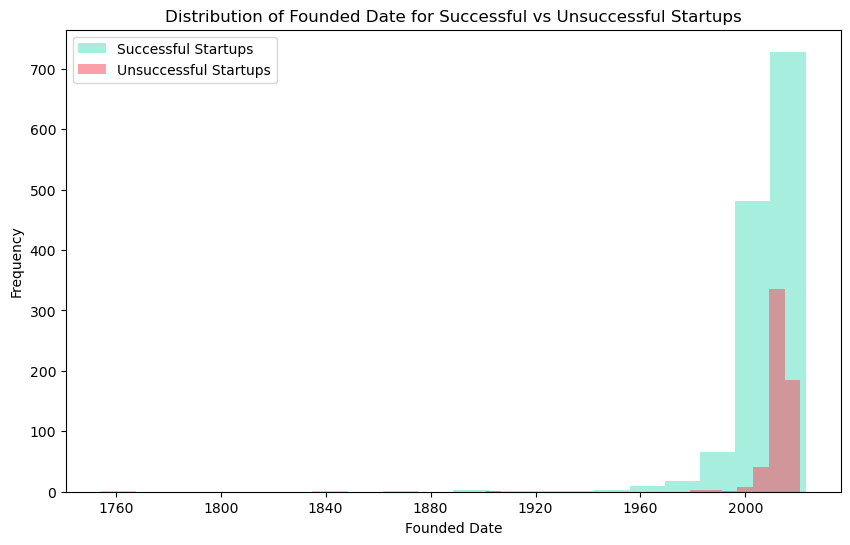

In [9]:
# Convert Founded Date column to datetime format
successful_df['Founded Date'] = pd.to_datetime(successful_df['Founded Date'])
unsuccessful_df['Founded Date'] = pd.to_datetime(unsuccessful_df['Founded Date'])

# Get summary statistics for Founded Date
successful_summary = successful_df['Founded Date'].describe()
unsuccessful_summary = unsuccessful_df['Founded Date'].describe()

# Display the summary statistics
print("Successful Startups Founded Date Summary:")
print(successful_summary)
print("\nUnsuccessful Startups Founded Date Summary:")
print(unsuccessful_summary)

plt.figure(figsize=(10, 6))
plt.hist(successful_df['Founded Date'], bins=20, alpha=0.5, color='#50DFBE', label='Successful Startups')
plt.hist(unsuccessful_df['Founded Date'], bins=20, alpha=0.5, color='#FA4056', label='Unsuccessful Startups')
plt.xlabel('Founded Date')
plt.ylabel('Frequency')
plt.title('Distribution of Founded Date for Successful vs Unsuccessful Startups')
plt.legend()
plt.show()

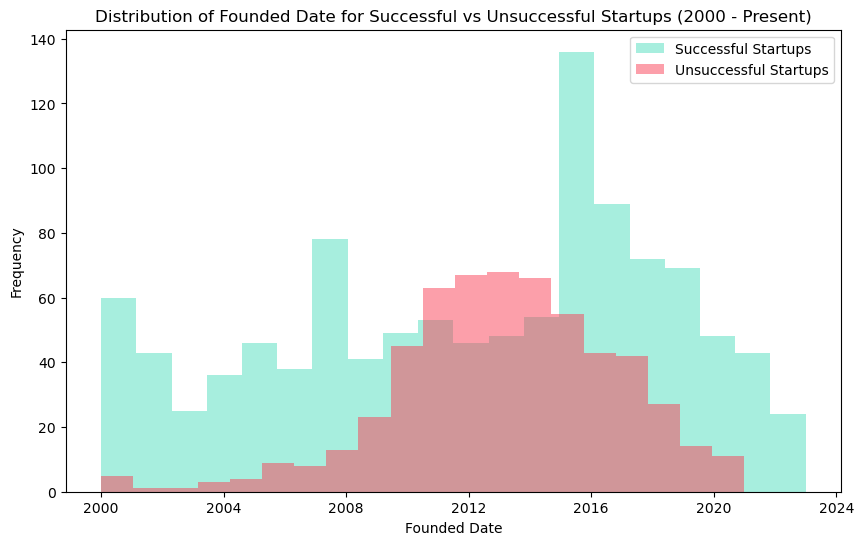

In [10]:
# Filter startups founded from 2000
successful_filtered = successful_df[successful_df['Founded Date'].dt.year >= 2000]
unsuccessful_filtered = unsuccessful_df[unsuccessful_df['Founded Date'].dt.year >= 2000]

# Plot histograms to compare the distribution of Founded Date
plt.figure(figsize=(10, 6))
plt.hist(successful_filtered['Founded Date'], bins=20, alpha=0.5, color='#50DFBE', label='Successful Startups')
plt.hist(unsuccessful_filtered['Founded Date'], bins=20, alpha=0.5, color='#FA4056', label='Unsuccessful Startups')
plt.xlabel('Founded Date')
plt.ylabel('Frequency')
plt.title('Distribution of Founded Date for Successful vs Unsuccessful Startups (2000 - Present)')
plt.legend()
plt.show()

## Insights

### Overall Trends:
- The number of **successful startups** shows fluctuations over the years, with a slight increasing trend from around 2000 to 2016, followed by some variations.
- Conversely, the number of **unsuccessful startups** displays more volatility, with peaks and valleys occurring across different years.

### Comparison Between Successful and Unsuccessful Startups:
- Successful startups generally outnumber **unsuccessful startups** in most years, indicating a higher overall success rate.
- Some years exhibit notably higher numbers of **unsuccessful startups**, particularly in the mid to late 2010s, suggesting potential challenges or market conditions leading to higher failure rates.

### Potential Insights:
- Years with more **successful startups** may signify periods of favorable market conditions, technological advancements, or supportive ecosystems.
- Conversely, years with increased **unsuccessful startups** could indicate economic downturns, regulatory changes, or market saturation.

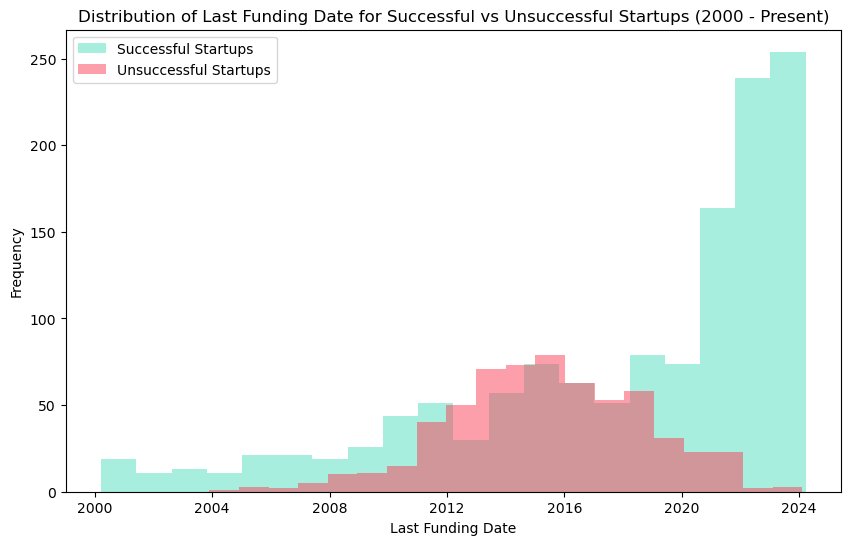

In [11]:
# Convert Last Funding Date column to datetime format
successful_df['Last Funding Date'] = pd.to_datetime(successful_df['Last Funding Date'])
unsuccessful_df['Last Funding Date'] = pd.to_datetime(unsuccessful_df['Last Funding Date'])

# Filter startups with Last Funding Date from 2000 to now
successful_df = successful_df[successful_df['Last Funding Date'].dt.year >= 2000]
unsuccessful_df = unsuccessful_df[unsuccessful_df['Last Funding Date'].dt.year >= 2000]

# Count the number of startups with Last Funding Date in each year for successful and unsuccessful startups
successful_count = successful_df['Last Funding Date'].dt.year.value_counts().sort_index()
unsuccessful_count = unsuccessful_df['Last Funding Date'].dt.year.value_counts().sort_index()

# Create a DataFrame to store the counts
startup_counts = pd.DataFrame({'Successful Startups': successful_count, 'Unsuccessful Startups': unsuccessful_count})

# Plot histograms to compare the distribution of Last Funding Date
plt.figure(figsize=(10, 6))
plt.hist(successful_df['Last Funding Date'], bins=20, alpha=0.5, color='#50DFBE', label='Successful Startups')
plt.hist(unsuccessful_df['Last Funding Date'], bins=20, alpha=0.5, color='#FA4056', label='Unsuccessful Startups')
plt.xlabel('Last Funding Date')
plt.ylabel('Frequency')
plt.title('Distribution of Last Funding Date for Successful vs Unsuccessful Startups (2000 - Present)')
plt.legend()
plt.show()

# Display the table
#print("Table: Number of Startups with Last Funding Date from 2000 to Present")
#print(startup_counts)

## Overall Trends:
- The number of successful startups with **Last Funding Date** shows some fluctuations over the years, with noticeable peaks in **2021** and **2023**.
- Conversely, the number of unsuccessful startups with **Last Funding Date** displays more variation, with peaks occurring in **2014** and **2015**, followed by a decline in recent years.

## Comparison Between Successful and Unsuccessful Startups:
- In most years, successful startups with **Last Funding Date** outnumber unsuccessful startups, indicating a higher overall success rate.
- However, there are some years where the number of unsuccessful startups surpasses successful ones, notably in **2011**, **2012**, **2013**, and **2014**, suggesting challenges or market conditions leading to higher failure rates during those periods.

## Potential Insights:
- The significant increase in the number of successful startups with **Last Funding Date** in **2021** and **2023** may indicate periods of favorable market conditions or increased investor confidence.
- Conversely, the decline in the number of unsuccessful startups with **Last Funding Date** in recent years could suggest improved business sustainability or a more selective investment environment.

In [12]:
successful_df['Industries'].head()

0    Employee Benefits, Human Resources, SaaS, Soft...
1    Health Care, Mental Health, mHealth, Therapeut...
2    Employee Benefits, Employment, Gamification, H...
3        Health Care, Information Technology, Software
4    Continuing Education, E-Learning, EdTech, Elde...
Name: Industries, dtype: object

In [13]:
# Analyze the 'Industries' column for successful startups
successful_industries = successful_df['Industries'].str.split(', ')
# Flatten the list of lists
flattened_successful_industries = [industry for sublist in successful_industries for industry in sublist]
# Count the occurrences of each industry
successful_industry_counts = Counter(flattened_successful_industries)

# Analyze the 'Industries' column for unsuccessful startups
unsuccessful_industries = unsuccessful_df['Industries'].str.split(', ')
# Flatten the list of lists
flattened_unsuccessful_industries = [industry for sublist in unsuccessful_industries for industry in sublist]
# Count the occurrences of each industry
unsuccessful_industry_counts = Counter(flattened_unsuccessful_industries)

# Combine the counts for successful and unsuccessful startups
all_industries_counts = successful_industry_counts + unsuccessful_industry_counts

# Get the top 10 most common industries
top_n = 10
top_industries = all_industries_counts.most_common(top_n)


top_industry = [industry for industry, _ in top_industries]
successful_counts = [successful_industry_counts[industry] for industry in top_industry]
unsuccessful_counts = [unsuccessful_industry_counts[industry] for industry in top_industry]

print("Top 10 Industries:")
for industry, count in top_industries:
    print(f"{industry}: {count}")


Top 10 Industries:
Health Care: 1436
Biotechnology: 722
Medical: 648
Medical Device: 369
Pharmaceutical: 250
Therapeutics: 243
Wellness: 188
Software: 177
Health Diagnostics: 149
Information Technology: 141


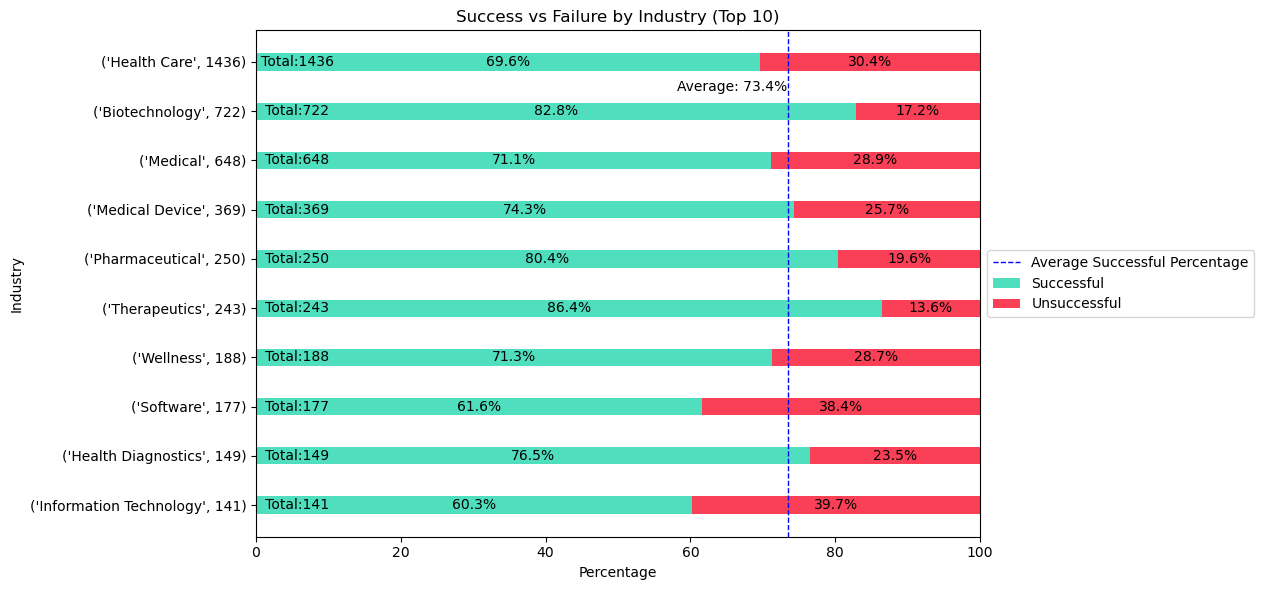

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
total_counts = np.array(successful_counts) + np.array(unsuccessful_counts)
successful_percentages = np.array(successful_counts) / total_counts * 100
unsuccessful_percentages = np.array(unsuccessful_counts) / total_counts * 100

# Calculate average successful percentage
average_successful_percentage = np.mean(successful_percentages)

# Generate a 100% stacked bar graph
plt.figure(figsize=(10, 6))
ind = np.arange(len(top_industries))
width = 0.35

p1 = plt.barh(ind, successful_percentages, width, label='Successful', color='#50DFBE')
p2 = plt.barh(ind, unsuccessful_percentages, width, left=successful_percentages, label='Unsuccessful', color='#FA4056')

plt.ylabel('Industry')
plt.xlabel('Percentage')
plt.title('Success vs Failure by Industry (Top 10)')
plt.yticks(ind, top_industries)
plt.tight_layout()

# Set the x-axis range from 0 to 100
plt.xlim(0, 100)

# Draw average line
plt.axvline(x=average_successful_percentage, color='blue', linestyle='--', linewidth=1, label='Average Successful Percentage')

# Display labels
for i, (success, failure) in enumerate(zip(successful_percentages, unsuccessful_percentages)):
    plt.text(success / 2, i, f"{success:.1f}%", ha='center', va='center')
    plt.text(success + failure / 2, i, f"{failure:.1f}%", ha='center', va='center')

# Display total counts for each industry
for i, total_count in enumerate(total_counts):
    plt.text(0, i, f"                   Total:{total_count}", ha='center', va='center')

# Annotate average value
plt.text(average_successful_percentage, len(top_industries)-9.5, f"Average: {average_successful_percentage:.1f}%", ha='right', va='center')

# Display the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gca().invert_yaxis()  # Invert the y-axis
plt.show()


## Key Insights on Industry

1. **Biotechnology** and **Therapeutics** exhibit the highest success rates among the top 10 industries, with percentages exceeding 80%. This highlights the strong potential and favorable conditions for startups in the biotech and therapeutic sectors.

2. **Health Care** and **Medical Device** industries also show promising success rates, both exceeding 70%. This indicates a robust ecosystem and market demand for innovations in healthcare and medical technology.

3. **Software**, while a prominent industry with a significant number of startups, has a comparatively lower success rate of around 61.58%. This suggests a more competitive landscape and challenges faced by software startups in achieving success.

4. **Pharmaceutical** startups, although fewer in number, demonstrate a commendable success rate of approximately 80.4%, indicating resilience and viability within the pharmaceutical industry.

5. **Information Technology**, while a prevalent sector, exhibits a relatively lower success rate of about 60.28%. This indicates a challenging environment for IT startups, possibly due to high competition and market saturation.

In [15]:
successful_df['Headquarters Location'].head()

0    San Francisco, California, United States
1     Cambridge, Massachusetts, United States
2           New York, New York, United States
3                Austin, Texas, United States
4    San Francisco, California, United States
Name: Headquarters Location, dtype: object

In [16]:
successful_df[['City', 'State', 'Country']] = successful_df['Headquarters Location'].str.split(', ', expand=True)
unsuccessful_df[['City', 'State', 'Country']] = unsuccessful_df['Headquarters Location'].str.split(', ', expand=True)

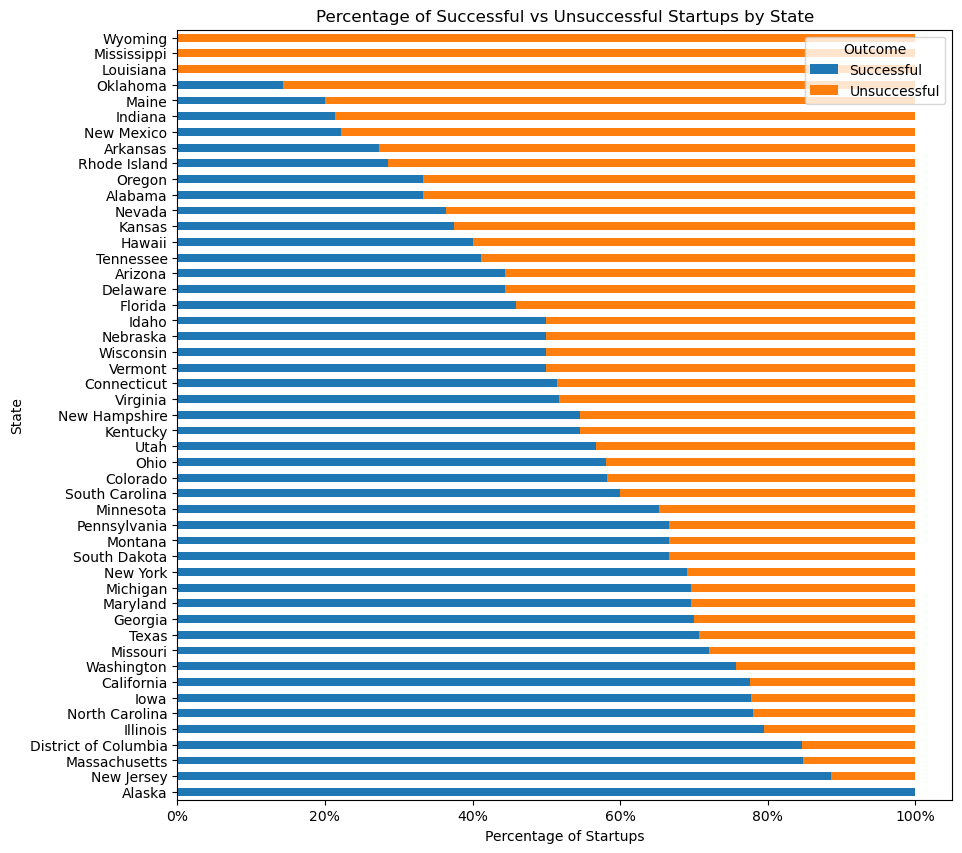

In [17]:
# Group by state and count the number of startups
successful_counts = successful_df['State'].value_counts()
unsuccessful_counts = unsuccessful_df['State'].value_counts()

# Create a DataFrame to store the counts
state_counts = pd.DataFrame({'Successful': successful_counts, 'Unsuccessful': unsuccessful_counts})

# Calculate the total number of startups for each state
state_totals = state_counts.sum(axis=1)

# Normalize the data to get percentages
state_percentages = state_counts.div(state_totals, axis=0) * 100

# Sort the states by successful rate
state_percentages_sorted = state_percentages.sort_values(by='Successful', ascending=False)

# Plot 100% stacked bar chart with x and y axis flipped
state_percentages_sorted.plot(kind='barh', stacked=True, figsize=(10, 10))
plt.ylabel('State')
plt.xlabel('Percentage of Startups')
plt.title('Percentage of Successful vs Unsuccessful Startups by State')
plt.legend(title='Outcome')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
plt.show()

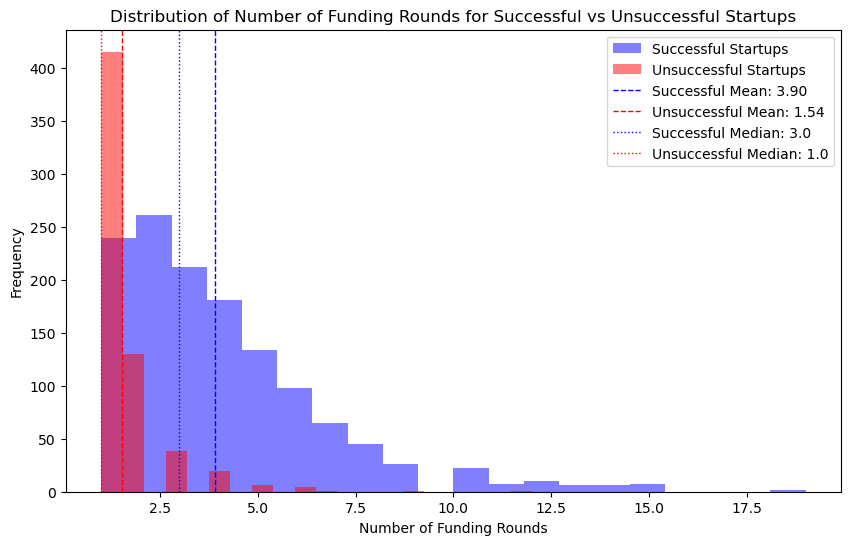

In [18]:
# Summary statistics
successful_funding_rounds = successful_df['Number of Funding Rounds']
unsuccessful_funding_rounds = unsuccessful_df['Number of Funding Rounds']

successful_mean = successful_funding_rounds.mean()
unsuccessful_mean = unsuccessful_funding_rounds.mean()

successful_median = successful_funding_rounds.median()
unsuccessful_median = unsuccessful_funding_rounds.median()

# Visualize the distributions
plt.figure(figsize=(10, 6))
plt.hist(successful_funding_rounds, bins=20, alpha=0.5, color='blue', label='Successful Startups')
plt.hist(unsuccessful_funding_rounds, bins=20, alpha=0.5, color='red', label='Unsuccessful Startups')
plt.axvline(successful_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Successful Mean: {successful_mean:.2f}')
plt.axvline(unsuccessful_mean, color='red', linestyle='dashed', linewidth=1, label=f'Unsuccessful Mean: {unsuccessful_mean:.2f}')
plt.axvline(successful_median, color='blue', linestyle='dotted', linewidth=1, label=f'Successful Median: {successful_median}')
plt.axvline(unsuccessful_median, color='red', linestyle='dotted', linewidth=1, label=f'Unsuccessful Median: {unsuccessful_median}')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Funding Rounds for Successful vs Unsuccessful Startups')
plt.legend()
plt.show()

## Insights

- **Successful startups**, on average, have participated in approximately **3.9 funding rounds**, with a standard deviation of **2.76**. The number of funding rounds for successful startups ranges from a **minimum of 1** to a **maximum of 19**, with **50%** of successful startups having participated in **3 or fewer rounds**, and **75%** in **5 or fewer rounds**.

- In contrast, **unsuccessful startups** have participated in an average of around **1.54 funding rounds**, with a lower standard deviation of approximately **1.06**. The number of funding rounds for unsuccessful startups ranges from **1 to 12**, with **50%** of unsuccessful startups participating in just **1 round**, and **75%** in **2 or fewer rounds**.

This suggests that **successful startups** tend to have a **higher number of funding rounds** compared to **unsuccessful startups**, indicating potentially **greater investor confidence** and ongoing support for their endeavors. Additionally, the **narrower spread** of funding rounds among **unsuccessful startups** may suggest a quicker cessation of funding or support in these cases.


In [19]:
successful_df['Number of Employees'].unique()

array(['101-250', '11-50', '51-100', '251-500', '1-10', '1001-5000',
       '501-1000', nan, '5001-10000', '10001+'], dtype=object)

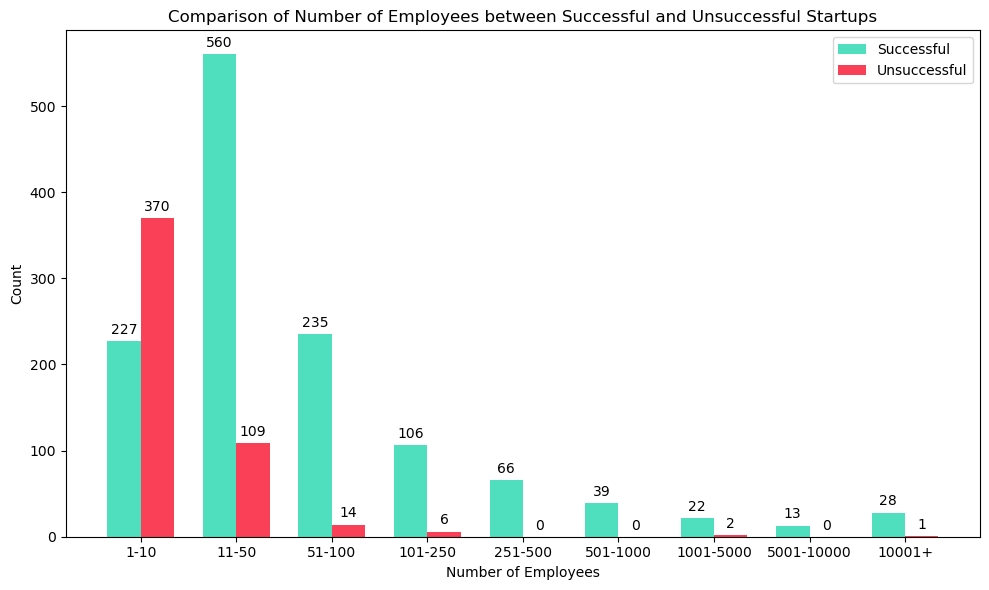

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate data from successful and unsuccessful startups
all_data = pd.concat([successful_df[['Number of Employees', 'Status']], unsuccessful_df[['Number of Employees', 'Status']]])

# Get unique categories and count occurrences for each status
employee_counts = all_data.pivot_table(index='Number of Employees', columns='Status', aggfunc='size', fill_value=0)

# Reorder the categories for better interpretation
employee_counts = employee_counts.reindex(['1-10', '11-50', '51-100', '101-250', '251-500', '501-1000', '1001-5000', '5001-10000', '10001+'])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.35

# Index for the x-axis ticks
index = range(len(employee_counts))

# Plotting bars for successful startups
bars1 = ax.bar(index, employee_counts['Successful'], bar_width, label='Successful', color='#50DFBE')

# Plotting bars for unsuccessful startups
bars2 = ax.bar([i + bar_width for i in index], employee_counts['Unsuccessful'], bar_width, label='Unsuccessful', color='#FA4056')

# Adding labels and title
ax.set_xlabel('Number of Employees')
ax.set_ylabel('Count')
ax.set_title('Comparison of Number of Employees between Successful and Unsuccessful Startups')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(employee_counts.index)
ax.legend()

# Adding counts above the bars
def add_counts(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_counts(ax, bars1)
add_counts(ax, bars2)

plt.tight_layout()
plt.show()


Based on the count table provided:

- **11-50 Employees**: Demonstrating the highest success rate with **560 successful startups** compared to **109 unsuccessful** ones, suggesting a trend of increased success with greater company size. Conversely, startups with **1-10 employees** exhibit a lower success rate, with **227 successful startups** against **370 unsuccessful** ones. Interestingly, the larger the startup, the fewer unsuccessful cases, with startups over **5000 employees** showing no unsuccessful cases, showcasing a strong correlation between company size and success. This suggests that while smaller startups face higher failure rates, larger ones tend to have more stable trajectories, possibly due to established resources and market positioning.


In [21]:
# Convert CB Rank (Company) column to integer datatype
# Remove commas from CB Rank (Company) column and convert to integer datatype
successful_df['CB Rank (Company)'] = successful_df['CB Rank (Company)'].str.replace(',', '').fillna(0).astype(int)
unsuccessful_df['CB Rank (Company)'] = unsuccessful_df['CB Rank (Company)'].str.replace(',', '').fillna(0).astype(int)


In [22]:

# Compare the distribution of CB Rank (Company) between successful and unsuccessful startups
successful_cb_rank = successful_df['CB Rank (Company)']
unsuccessful_cb_rank = unsuccessful_df['CB Rank (Company)']

# Calculate the mean CB Rank for each group
successful_mean_cb_rank = successful_cb_rank.mean()
unsuccessful_mean_cb_rank = unsuccessful_cb_rank.mean()

print("Successful Mean CB Rank:", successful_mean_cb_rank)
print("Unsuccessful Mean CB Rank:", unsuccessful_mean_cb_rank)

# Perform a t-test to determine if there is a statistically significant difference in CB Rank between successful and unsuccessful startups
t_stat, p_value = ttest_ind(successful_cb_rank, unsuccessful_cb_rank)

print("t-statistic:", t_stat)
print("p-value:", p_value)


Successful Mean CB Rank: 157811.18395155185
Unsuccessful Mean CB Rank: 883481.0389610389
t-statistic: -25.123058059687775
p-value: 8.768783211049003e-121


## Insights from t-test

Comparing the distribution of CB Rank (Company) between successful and unsuccessful startups reveals notable differences. Successful startups exhibit a considerably lower mean CB Rank (**157,811.18**) compared to unsuccessful startups (**883,481.04**), indicating a higher ranking for successful ventures. The statistically significant t-statistic (**-25.12**) and extremely low p-value (**8.77e-121**) further confirm this distinction, suggesting a substantial difference in CB Rank distributions between the two groups. This implies that CB Rank (Company) could serve as a predictive factor for startup success, with lower-ranked startups being more likely to succeed.


## Feature Engineering

In [23]:
successful_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1321 entries, 0 to 1321
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Organization Name            1321 non-null   object        
 1   Full Description             1298 non-null   object        
 2   Founded Date                 1314 non-null   datetime64[ns]
 3   Number of Employees          1296 non-null   object        
 4   Industries                   1321 non-null   object        
 5   Headquarters Location        1321 non-null   object        
 6   Description                  1321 non-null   object        
 7   CB Rank (Company)            1321 non-null   int64         
 8   Operating Status             1321 non-null   object        
 9   Number of Founders           1086 non-null   float64       
 10  Founders                     1086 non-null   object        
 11  Number of Funding Rounds     1321 non-null   int

In [24]:
successful_df['Status'] = 1
unsuccessful_df['Status'] = 0
df = pd.concat([successful_df, unsuccessful_df], ignore_index=True)

In [25]:
df['Status'] = df['Status'].astype(int)

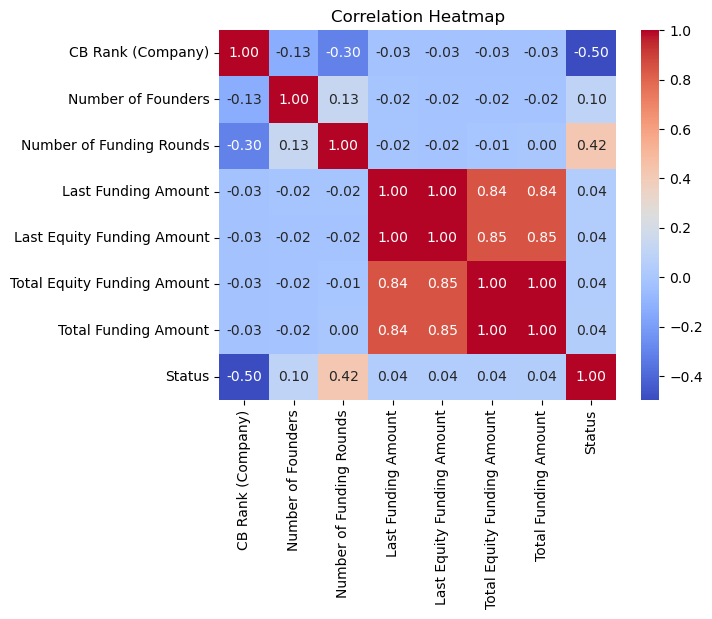

In [26]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Create a correlation matrix
corr_matrix = numerical_df.corr()

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title and show the plot
plt.title('Correlation Heatmap')
plt.show()

In [27]:
keep_columns = ['CB Rank (Company)', 'Number of Founders', 'Number of Funding Rounds', 'Industries', 'Status']
df = df[keep_columns]

In [28]:
# Split 'Industries' by delimeter
industries_split = df['Industries'].str.split(', ', expand=True)

# Convert the DataFrame to a Series
industries_series = industries_split.stack()

# Drop the NaN values
industries_series = industries_series.dropna()

# Convert the Series to a list
industries_vector = industries_series.tolist()

# Remove duplicates from the list
industries_vector = list(set(industries_vector))

# Create Dataframe with Column Names
industry_df = pd.DataFrame(columns=industries_vector)

In [29]:
# Concatenate the new_df with the original my_df
df = pd.concat([df, industry_df], axis=1)

# Iterate through each row of the result_df
for index, row in df.iterrows():
    # Get the list of industries for the current row
    industries = row['Industries'].split(', ')

    # Iterate through each column in the new_df
    for col in industry_df.columns:
        # Check if the column name is present in the list of industries
        if col in industries:
            # Set the value to 1 if present
            df.at[index, col] = 1
        else:
            # Set the value to 0 if not present
            df.at[index, col] = 0

# Convert the columns to numeric
df[industry_df.columns] = df[industry_df.columns].apply(pd.to_numeric)

In [30]:
df.drop('Industries', axis=1, inplace=True)

In [31]:
df.shape

(1937, 325)

In [32]:
X = df.drop('Status', axis=1)
X = X.fillna(0)
y = df['Status']

In [33]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [34]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1549, 324) (388, 324) (1549,) (388,)


In [35]:
from sklearn.metrics import confusion_matrix

# Create and train the logistic regression model
model = LogisticRegression(multi_class='auto', max_iter=1000)  # Using default parameters
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_logreg)

# Additional evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8402061855670103
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       128
           1       0.85      0.93      0.89       260

    accuracy                           0.84       388
   macro avg       0.83      0.79      0.81       388
weighted avg       0.84      0.84      0.83       388

Confusion Matrix:
[[ 84  44]
 [ 18 242]]


In [36]:
# Initialize and train the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_xgb:.2f}")

# Generate confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_xgb)


# Save the XGBoost model
xgb_clf.save_model('xgboost_model.txt')

Accuracy: 0.90
Confusion Matrix:
[[115  13]
 [ 24 236]]


In [37]:
X.head()

,CB Rank (Company),Number of Founders,Number of Funding Rounds,Supply Chain Management,Nutrition,Search Engine,Logistics,Nutraceutical,Advice,Electronics,Social Network,Professional Services,Organic,Marketplace,Location Based Services,Product Design,Family,Computer Vision,Video Chat,DIY,Children,Robotics,Plant-Based Foods,Sales Automation,Consumer,GreenTech,Information and Communications Technology (ICT),Banking,Hospitality,Grocery,Mobile Apps,Facility Management,Human Resources,Pharmaceutical,Personal Health,Software Engineering,Life Science,Chemical,Cloud Data Services,Advanced Materials,Communities,Artificial Intelligence (AI),Technical Support,Dental,Home Health Care,Video Games,Simulation,Home Decor,Retail,Cloud Management,Developer Tools,Machine Learning,Insurance,Cannabis,Bioinformatics,Diabetes,Intelligent Systems,Management Consulting,Facilities Support Services,Aquaculture,Medical Device,Consumer Research,Web Development,Web Hosting,Fashion,Big Data,Content,RFID,Alternative Protein,Electronic Health Record (EHR),Aerospace,Application Performance Management,Furniture,3D Printing,Analytics,Scheduling,Apparel,Assisted Living,Travel,Semiconductor,Leasing,Adult,Hardware,Health Insurance,Finance,Data Collection and Labeling,Animal Feed,Lighting,Residential,Intrusion Detection,Therapeutics,Personal Care and Hygiene,Education,Compliance,mHealth,Software,Quantum Computing,Telecommunications,Virtualization,Food Trucks,Biotechnology,Consumer Electronics,Biopharma,Fertility,Local,Agriculture,Psychology,Credit Cards,Men's,Security,Lending,Data Integration,Precision Medicine,Mobile Payments,Wholesale,Private Social Networking,Product Research,B2B,Social Impact,Predictive Analytics,Online Games,Management Information Systems,Developer APIs,Enterprise Software,Consulting,Real Estate,FinTech,Payments,Retirement,Baby,Coworking,Video,Leisure,Information Technology,Art,File Sharing,Hospital,Cloud Computing,Tourism,Direct Sales,Fitness,Packaging Services,Internet,Document Management,Eyewear,Beauty,Social Media,Productivity Tools,Data Center Automation,Parenting,DevOps,Cyber Security,Child Care,Neuroscience,Advertising,Data Mining,Service Industry,Social CRM,Commercial,Online Portals,QR Codes,Clinical Trials,Procurement,Property Management,Property Development,Virtual Workforce,Pet,Emergency Medicine,Same Day Delivery,Gaming,Addiction Treatment,EdTech,Sports,Natural Language Processing,Tour Operator,Mental Health,Delivery,Telehealth,Virtual Desktop,Events,Recipes,Manufacturing,Veterinary,Training,Business Intelligence,Identity Management,Risk Management,Consumer Goods,Plastics and Rubber Manufacturing,Mobile Devices,Social Media Marketing,InsurTech,Video Streaming,Automotive,Wellness,Hotel,Nanotechnology,App Discovery,Legal,Continuing Education,Test and Measurement,Dietary Supplements,Landscaping,Non Profit,Customer Service,Lifestyle,Flowers,Android,Religion,Event Management,Snack Food,Gamification,Business Development,E-Commerce,Industrial,Quantified Self,Shopping,Business Process Automation (BPA),Data Management,Outpatient Care,Homeland Security,Mobile Advertising,Media and Entertainment,National Security,Delivery Service,Mobile,E-Commerce Platforms,AgTech,Nursing and Residential Care,Smart Building,Alternative Medicine,Textiles,Augmented Reality,Oncology,iOS,Internet of Things,Public Safety,Loyalty Programs,Music,Virtual Reality,Real Time,Retail Technology,Point of Sale,Subscription Service,Organic Food,Cosmetics,Data Visualization,Blockchain,News,Brewing,Staffing Agency,Health Diagnostics,Computer,Sharing Economy,Innovation Management,Farming,Billing,Higher Education,Natural Resources,Apps,SaaS,Legal Tech,Web Apps,Open Source,Sales,Sustainability,Cryptocurrency,Clean Energy,Health Care,Information Services,Architecture,Employee Benefits,Web Browsers,Market Research,CleanTech,Messaging,Laser,Sales Enablement,Tobacco,Universities,Personal Finance,Recruiting,Recreation,Wireless,Project Management,E-Learning,Medical,Chatbot,Direct Marketi

In [39]:
# Retrain the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Create a function to add the XGBoost prediction to the new_df
def add_prediction(df):
    # Make a prediction using the XGBoost model
    proba = xgb_clf.predict_proba(df)
    # Print the probability of success
    prob_success = proba[:, 1][0]
    print('Probability of success:', prob_success)
    # Determine outcome based on threshold
    outcome = 'successful' if prob_success >= 0.5 else 'unsuccessful'
    print('Predicted outcome:', outcome)

# Create a new dataframe with the same columns as the original dataset and a first row of zeros
new_df = pd.DataFrame(0, index=[0], columns=X.columns)

# Create a HBox to display the text boxes and their descriptions side by side
text_boxes = [widgets.FloatText(value=0, layout=widgets.Layout(width='100px')) for _ in range(3)]
text_box_widgets = [
    widgets.HBox([widgets.Label(value=X.columns[i], layout=widgets.Layout(width='200px')), text_box])
    for i, text_box in enumerate(text_boxes)
]

# Create a dropdown menu with a search bar
dropdown = widgets.SelectMultiple(
    options=X.columns[3:],
    value=(),  # Set the default value to an empty tuple
    disabled=False,
    layout=widgets.Layout(width='400px')
)

search_bar = widgets.Text(
    value='',
    placeholder='Search industry',
    continuous_update=False,
    layout=widgets.Layout(width='200px')
)

dropdown_with_search = widgets.VBox([search_bar, dropdown])

# Create a function to filter the dropdown options
def filter_options(search_text):
    filtered_options = [option for option in X.columns[4:] if search_text.lower() in option.lower()]
    dropdown.options = filtered_options

# Connect the search bar to the filter function
search_bar.observe(lambda change: filter_options(change.new), names='value')

# Create an HBox to display the dropdown menu and its description
dropdown_box = widgets.HBox([
    widgets.Label(value='Select features:', layout=widgets.Layout(width='150px')),
    dropdown_with_search
])

# Create a button widget
submit_button = widgets.Button(description="Submit")

# Create a function to display the updated table
def on_button_clicked(b):
    display(new_df)
    # Add the XGBoost prediction to the new_df
    add_prediction(new_df)

# Connect the function to the button
submit_button.on_click(on_button_clicked)

# Create a function to update the new dataframe when the dropdown menu selection changes
def on_dropdown_change(change):
    selected_options = change['new']
    for col in X.columns[3:]:
        if col in selected_options:
            new_df.loc[0, col] = 1
        else:
            new_df.loc[0, col] = 0

# Connect the function to the dropdown menu
dropdown.observe(on_dropdown_change, names='value')

# Create a function to update the new dataframe when the text boxes change
def on_text_change(change):
    for i, text_box in enumerate(text_boxes):
        new_df.iloc[0, i] = text_box.value

# Connect the function to the text boxes
for text_box in text_boxes:
    text_box.observe(on_text_change, names='value')

# Display the input widgets
display(*text_box_widgets, dropdown_box, submit_button)


Button(description='Submit', style=ButtonStyle())